The approach

1. Decide on ML task: Regression or classification
2. Download the Data
3. Understand it, explore it and visualize it
4. Handle missing values and outliers
5. Feature selection and Feature extraction
6. Feature scaling
7. Train model
8. Predict
9. Evaluate

In [1]:
# Importing necessary library
import pandas as pd
import numpy as np
from datetime import datetime
#import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

# Set the seaborn visualization style
sns.set()

In [2]:
df = pd.read_csv('TSLA.csv', index_col='Date')

In [3]:
# Make the copy of the data. We will work on the copied data.
data = df.copy()

### Inspect the Data

In [4]:
# Inspect the data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,152.320007,153.199997,148.660004,150.429993,150.429993,4262400
2014-01-02,149.800003,152.479996,146.550003,150.100006,150.100006,6188400
2014-01-03,150.000000,152.190002,148.600006,149.559998,149.559998,4695000
2014-01-06,150.000000,150.399994,145.240005,147.000000,147.000000,5361100
2014-01-07,147.619995,150.399994,145.250000,149.360001,149.360001,5034100


In [5]:
# Check the shape of the data
data.shape

(1510, 6)

### Generating Returns and Target Values

Let's say we want to predict the next days movement: up or down. What kind of ML problem would it be? It would be a classification task. And for that purpose, we need to create our target values. Let's create it.

In [6]:
# Generate log returns
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))

If the next day is up day, we will designate it with 1, else if it is a down day, we will mark it with -1.

In [7]:
# Create target values
data['target'] = np.where(data.returns.shift(-1) > 0, 1, -1)

In [8]:
# Count the values in the target column
data['target'].value_counts()

 1    761
-1    749
Name: target, dtype: int64

In [9]:
features = ['Volume','returns']
label = 'target'


### Feature Selection

We have OHLCV data with us. These OHCLV columns are our features. Based on this data, we will try to predict the next day's movement. But let's first understand which of these features can actually be used. Our intuition says that Close price plays the major role in the determining the next days movement. So we'll be considering it. What about other features.

To decide on what features to use and which one to ignore, let's analyze their relationship, starting with the Volume column.

In [10]:
data['target'].value_counts()

 1    761
-1    749
Name: target, dtype: int64

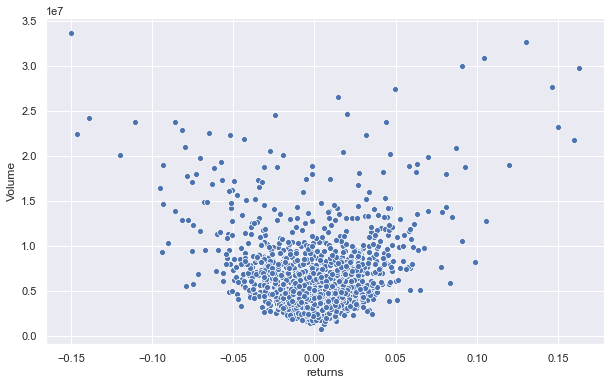

In [11]:
# Scatter plot of Close and Volume
plt.figure(figsize=(10,6))
sns.scatterplot(x=data['returns'], y=data['Volume']);

### Feature Extraction

If we ignore these features, we would left with only two variables, viz `Close` and `Volume`. Our intuition says that only these two features might not be able to capture to intricacies of the stock movement. We need more features. What we can do to generate more features? The answer is, create or extract new features based on the existing ones.

Let's try to create new features. We will consider the following quantitative features.

- Rolling standard deviation
- Rolling moving average of close price
- Rolling percentage change
- Rolling moving average of volume
- Difference between close and open

In [12]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Feature based on volume
col_name = 'vma_4'
data[col_name] = data['Volume'].rolling(4).mean()
features_list.append(col_name)

# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

This process of extracting information from the existing features is called feature extraction. We now have a handful of features as shown below. 

In [13]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'vma_4',
 'co']

We'll be using these features to predict the next days movement. We won't be using the `Close` and `Volume` columns. Now, is the time to generate our train and test data. Onwards to it.

As we are dealing with time-series data, we need to split our data set in such a way that it doesn't have a lookahead bias. But before we do it, can you think of any potential issue. Again, resorting to our old friend `.info()` will help us see for any potential issues.

Yes, there is an issue. There are many null values in many features. We need to get rid of them before we move further.

In [14]:
# Removing nan values
data.dropna(inplace=True)

In [15]:
data[features_list+['target']].head()

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co,target
Date,,,,,,,,,,,,,
2014-02-05,3.358835,4.044919,5.163403,177.384000,175.612666,168.966499,165.031199,-0.038671,-0.020722,-0.035616,6307000.0,-3.880005,1
2014-02-06,2.545262,3.805397,4.101563,177.072000,176.562666,170.321500,166.149200,0.007736,0.019641,0.025104,6140200.0,2.080002,1
2014-02-07,4.519428,4.707440,4.531228,178.264999,177.599999,172.271500,167.606400,0.044278,0.021901,0.099315,6681100.0,5.520004,1
2014-02-10,8.796296,6.556036,6.223964,180.959000,179.369999,174.813499,169.486400,0.122164,0.083493,0.101442,8752200.0,7.220001,1
2014-02-11,10.191657,8.111585,7.588278,182.782999,180.699333,177.677499,171.471199,0.099766,0.107502,0.119406,9612675.0,-2.350006,-1


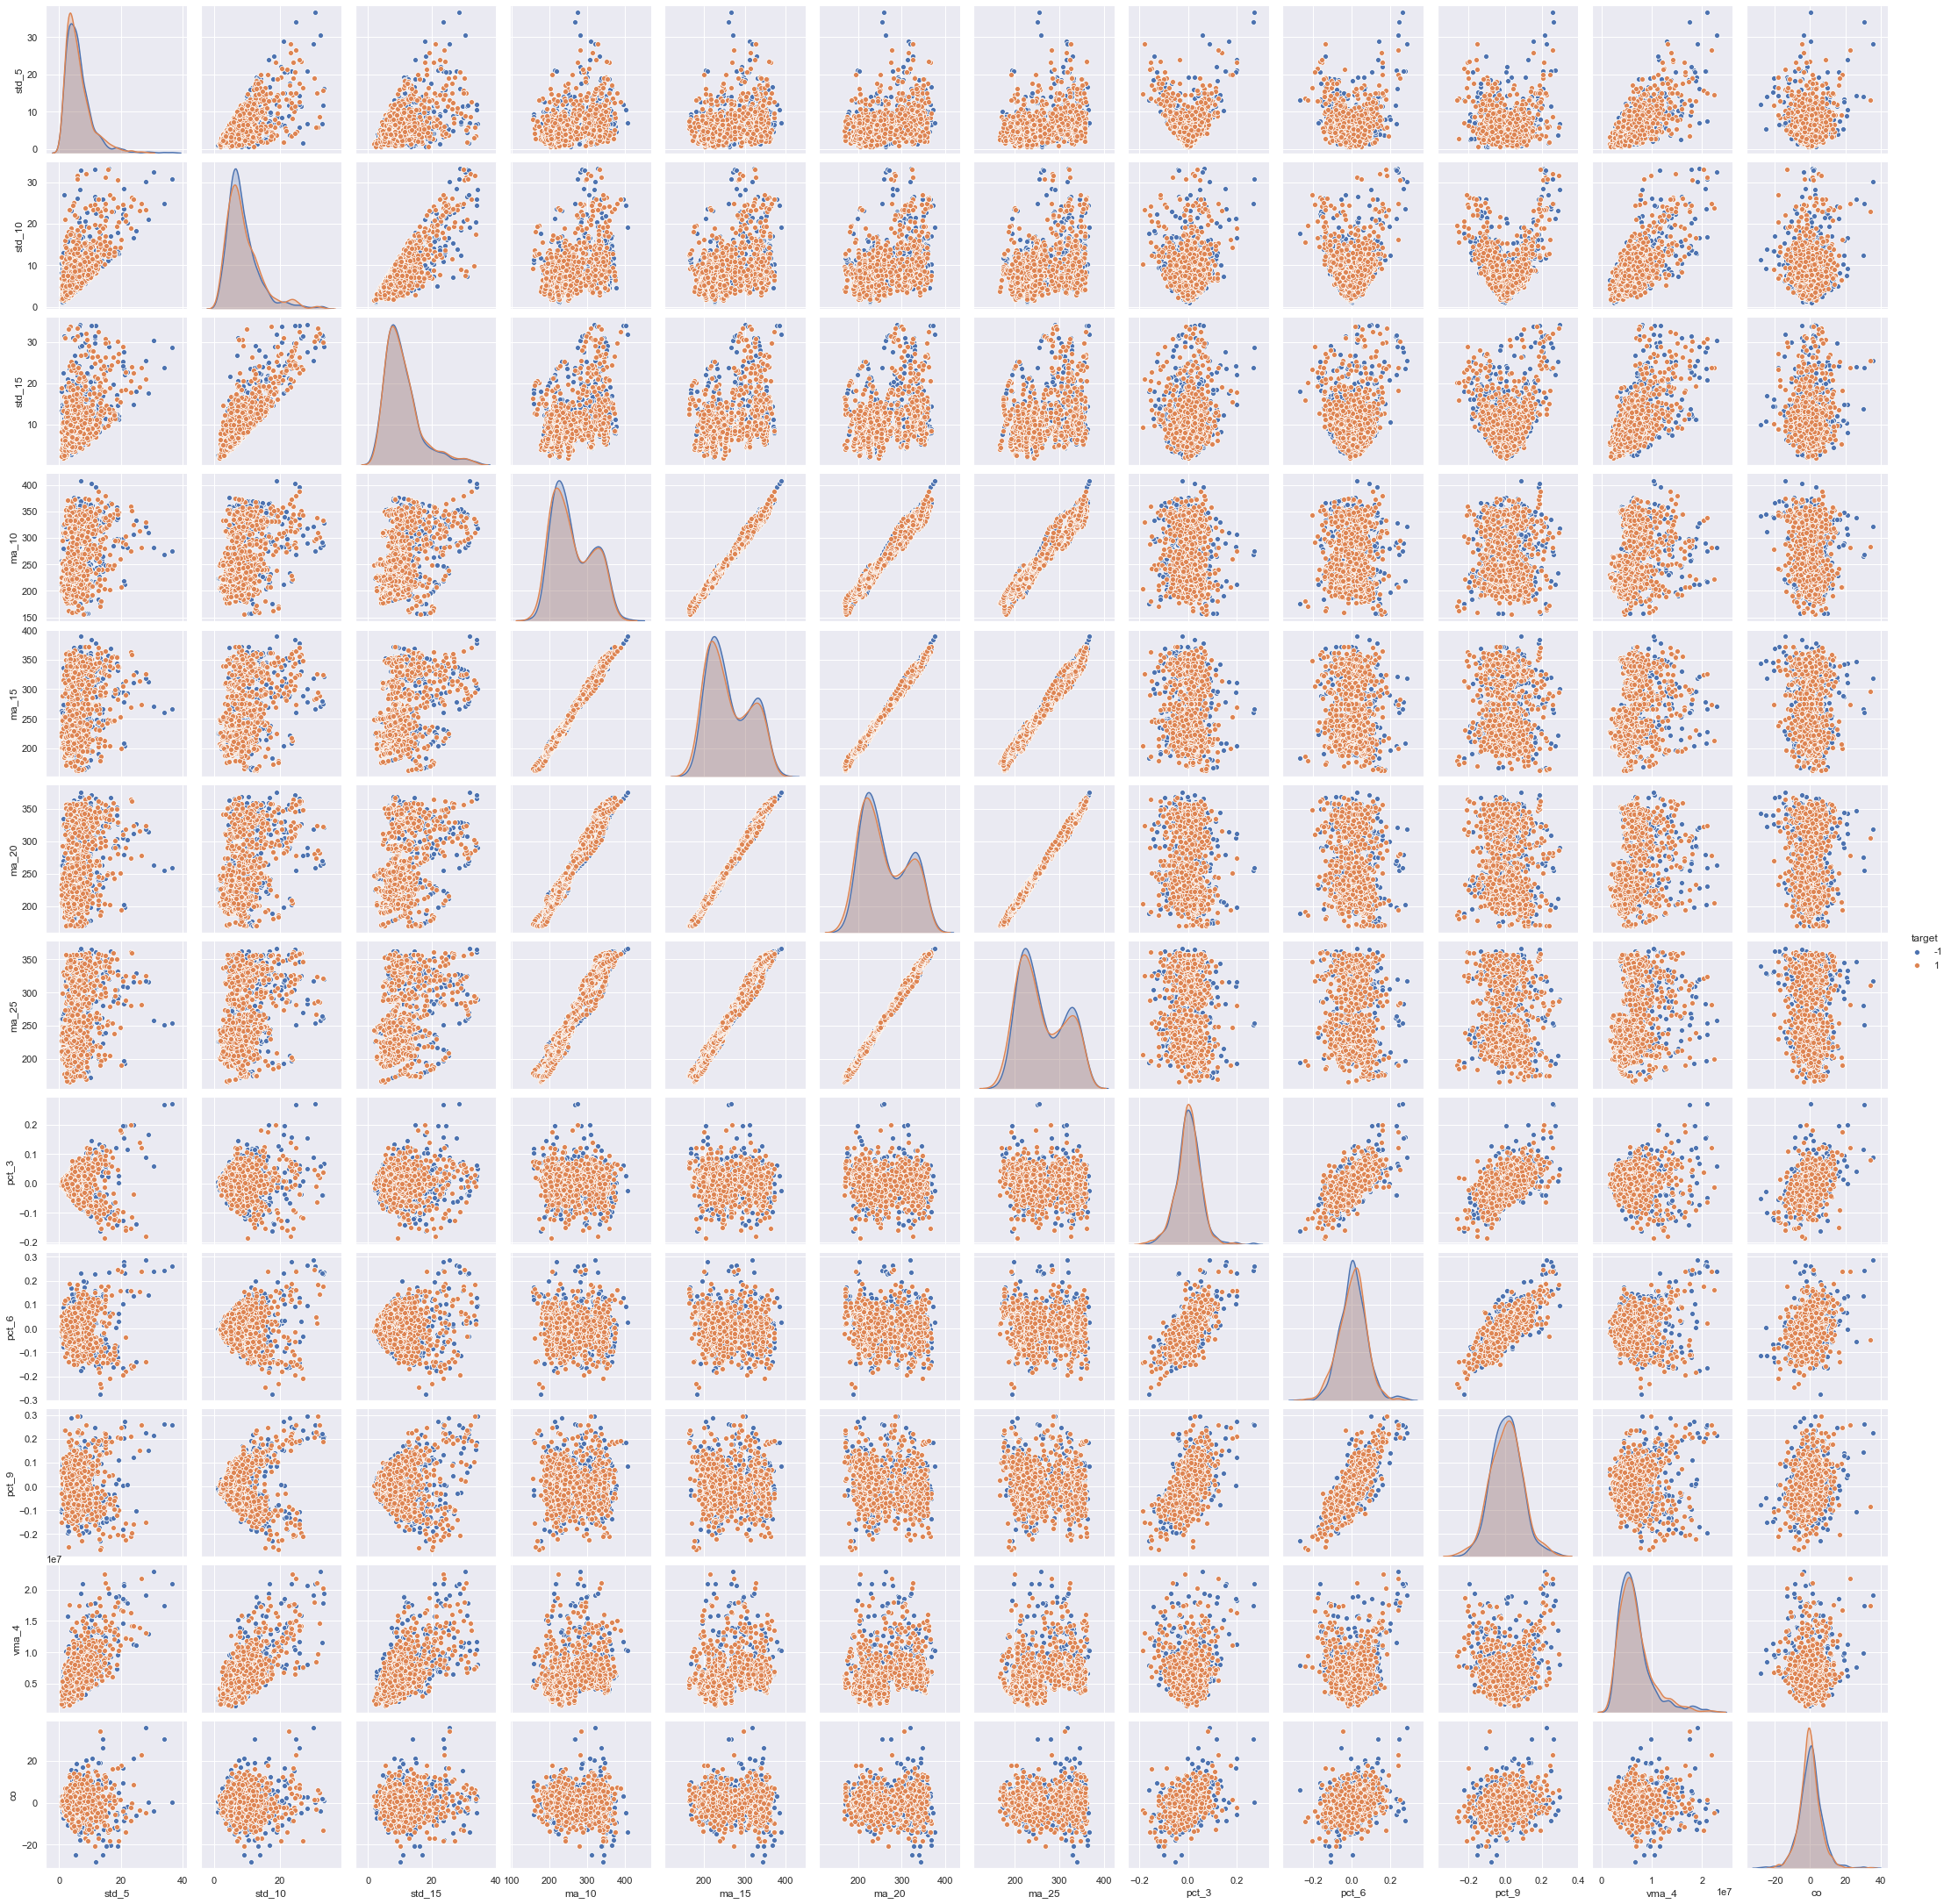

In [16]:
sns.pairplot(data[features_list+['target']],hue='target')

### Generating Training and Testing Datasets

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train , X_test,Y_train,Y_test = train_test_split(data[features_list].iloc[:-1],
                                                   data.iloc[:-1]['target'],
                                                   test_size= 0.2)
X_train.shape, Y_train.shape,X_test.shape, Y_test.shape

((1188, 12), (1188,), (297, 12), (297,))

### Feature Scaling

Now, we are almost ready to train our model and start predicting. But many ML algorithms requires normalized data. So, we need to make sure that the data we feed to our model is normalized. For that purpose, let's start by analyzing the data distribution of the features.

In [19]:
X_train.columns

Index(['std_5', 'std_10', 'std_15', 'ma_10', 'ma_15', 'ma_20', 'ma_25',
       'pct_3', 'pct_6', 'pct_9', 'vma_4', 'co'],
      dtype='object')

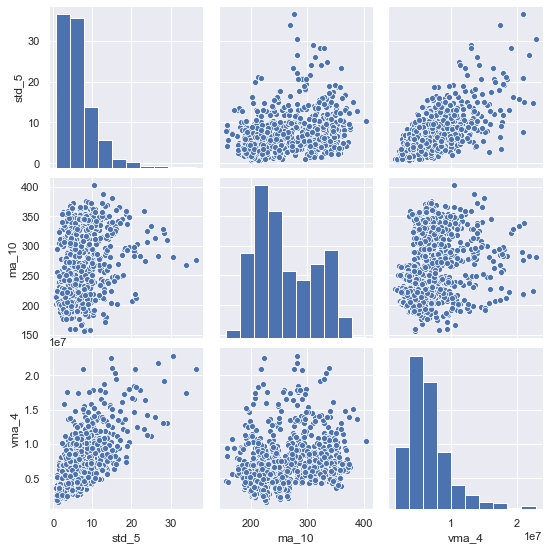

In [20]:
sns.pairplot(X_train[['std_5','ma_10','vma_4']])

From the above plot we can see that features have different distribution and their scales are different. Hence, it won't be a good idea to feed these data as it is to the ML algorithm. We need to scale the data. We can use `StandardScaler` package from the `sklearn` library to do so.

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
# Scaling the features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

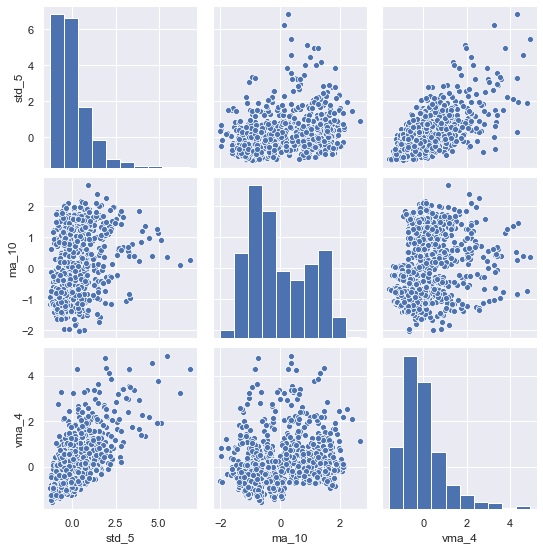

In [23]:
X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)
sns.pairplot(X_train_scaled_df[['std_5','ma_10','vma_4']])

From the above plot, we can see that values are now scaled with mean 0 and std 1. Another, interesting thing to note about `StandardScaler` is that is just scales the values, it doesn't change the data distribution.

Likewise, all features will now have mean 0 and std 1. 

In [24]:
X_train_scaled_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
std_5,1188.0,0.0,1.0,-1.29,-0.68,-0.21,0.38,6.85
std_10,1188.0,0.0,1.0,-1.52,-0.66,-0.27,0.41,4.63
std_15,1188.0,-0.0,1.0,-1.56,-0.69,-0.24,0.40,4.00
ma_10,1188.0,-0.0,1.0,-2.02,-0.81,-0.24,0.92,2.68
ma_15,1188.0,-0.0,1.0,-1.90,-0.82,-0.25,0.91,2.36
ma_20,1188.0,0.0,1.0,-1.80,-0.82,-0.27,0.94,2.14
ma_25,1188.0,0.0,1.0,-1.88,-0.82,-0.28,0.96,2.03
pct_3,1188.0,-0.0,1.0,-3.72,-0.56,0.01,0.57,5.28
pct_6,1188.0,-0.0,1.0,-3.93,-0.64,0.00,0.61,3.96
pct_9,1188.0,0.0,1.0,-3.20,-0.66,-0.00,0.63,3.37


Now that we have our data scaled, we can start training our model. We will use `LogisticRegression` algorithm.

In [25]:
# Import necessary package
from sklearn.linear_model import LogisticRegression

In [27]:
# Create model
model = LogisticRegression(C=1e5, random_state=1)

# Train model
model.fit(X_train_scaled, Y_train)

LogisticRegression(C=100000.0, random_state=1)

Finally, we have arrived at the most interesting point, where we can predict. Let's do it.

In [28]:
# Predict on train dataset
Y_pred_train = model.predict(X_train_scaled)

In [29]:
print('Model accuracy on training data:', model.score(X_train_scaled, Y_train))

Model accuracy on training data: 0.5580808080808081


In [30]:
# Predict on test dataset
Y_pred = model.predict(X_test_scaled)

In [31]:
print('Model accuracy on testing data:', model.score(X_test_scaled, Y_test))

Model accuracy on testing data: 0.4612794612794613


In [32]:
# Another method to calculate accuracy
from sklearn.metrics import accuracy_score

print('Model accuracy on training data:', accuracy_score(Y_train, Y_pred_train))
print('Model accuracy on testing data:', accuracy_score(Y_test, Y_pred))

Model accuracy on training data: 0.5580808080808081
Model accuracy on testing data: 0.4612794612794613


In [33]:
# Importing necessary packages
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
# Printing confusion matrix
print(confusion_matrix(Y_test, Y_pred))

[[62 92]
 [68 75]]


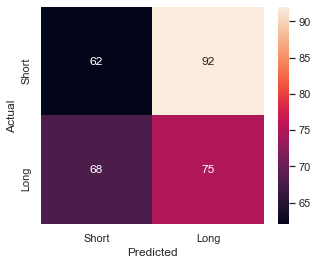

In [35]:
# Plotting Confustion matrix
cm = confusion_matrix(Y_test, Y_pred)
df = pd.DataFrame(cm, index=['Short', 'Long'], columns=['Short', 'Long'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
# Printing classification report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       0.48      0.40      0.44       154
           1       0.45      0.52      0.48       143

    accuracy                           0.46       297
   macro avg       0.46      0.46      0.46       297
weighted avg       0.46      0.46      0.46       297

